# Global Sea Temperatures Between 1972 & 2013
### Global Ocean Data Analysis Project
### National Oceanic and Atmospheric Administration

#### Imports

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns

from scipy import stats
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate
from sklearn.linear_model import RidgeCV


from math import ceil
from pandas.tools.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler
import functools

from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso, ElasticNet
from sklearn.pipeline import Pipeline

from basis_expansions.basis_expansions import (
    Polynomial, LinearSpline, NaturalCubicSpline)

from regression_tools.dftransformers import (
    ColumnSelector, Identity, FeatureUnion, MapFeature, Intercept)

from regression_tools.plotting_tools import (
    plot_univariate_smooth,
    bootstrap_train,
    display_coef,
    plot_bootstrap_coefs,
    plot_partial_depenence,
    plot_partial_dependences,
    predicteds_vs_actuals)

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('bmh')

import warnings
warnings.filterwarnings('ignore')

#### Data Cleaning

In [2]:
df = pd.read_csv('data/0-data/data_product/GLODAPv2 Merged Master File.csv')

In [3]:
key_words = '/Users/erindesmond/Documents/Galvanize/Case-Studies/my_studies/Climate-Temp/1.1/data/0-data'

In [4]:
print(list(df.columns))

['cruise', 'station', 'cast', 'year', 'month', 'day', 'hour', 'minute', 'latitude', 'longitude', 'bottomdepth', 'maxsampdepth', 'bottle', 'pressure', 'depth', 'temperature', 'theta', 'salinity', 'salinityf', 'salinityqc', 'sigma0', 'sigma1', 'sigma2', 'sigma3', 'sigma4', 'gamma', 'oxygen', 'oxygenf', 'oxygenqc', 'aou', 'aouf', 'nitrate', 'nitratef', 'nitrateqc', 'nitrite', 'nitritef', 'silicate', 'silicatef', 'silicateqc', 'phosphate', 'phosphatef', 'phosphateqc', 'tco2', 'tco2f', 'tco2qc', 'talk', 'talkf', 'talkqc', 'phts25p0', 'phts25p0f', 'phtsinsitutp', 'phtsinsitutpf', 'phtsqc', 'cfc11', 'pcfc11', 'cfc11f', 'cfc11qc', 'cfc12', 'pcfc12', 'cfc12f', 'cfc12qc', 'cfc113', 'pcfc113', 'cfc113f', 'cfc113qc', 'ccl4', 'pccl4', 'ccl4f', 'ccl4qc', 'sf6', 'psf6', 'sf6f', 'c13', 'c13f', 'c14', 'c14f', 'c14err', 'h3', 'h3f', 'h3err', 'he3', 'he3f', 'he3err', 'he', 'hef', 'heerr', 'neon', 'neonf', 'neonerr', 'o18', 'o18f', 'toc', 'tocf', 'doc', 'docf', 'don', 'donf', 'tdn', 'tdnf', 'chla', 'chlaf

In [5]:
df.shape

(999448, 101)

WOCE flag value
0 1 2 3 4 5 6 7 8 9
Interpretation in original data/product files
* Not used/interpolated or calculated value -0
* Data not received/not used -1
* Acceptable/acceptable -2
* Questionable/not used -3
* Bad/not used -4
* Value not reported/not used -5
* Average of replicate/not used -6
* Manual chromatographic peak measurement/not used -7
* Irregular digital peak measurement/not used -8
* Sample not drawn/no data -9
 

In [6]:
# Convert all rows with -9999 to NaN so they can be dropped.
df = df.replace([-9999, -999, -8888, -888, -7777, -777, -6666, -666],np.NaN)

In [7]:
# Drop duplicated rows

df.duplicated()
df.drop_duplicates(inplace=True);

In [8]:
def get_percentage_missing(series):
    """ Calculates percentage of NaN values in DataFrame
    :param series: Pandas DataFrame object
    :return: float
    """
    num = series.isnull().sum()
    den = len(series)
    return round(num/den, 2)

# Only include columns that contain any NaN values
df_with_any_null_values = df[df.columns[df.isnull().any()].tolist()]

get_percentage_missing(df_with_any_null_values);

In [9]:
max_depth = df['maxsampdepth'].max()
max_depth

7682.0

## EDA of Sea Temperatures Over Time

#### Variability in Temperature Through Time

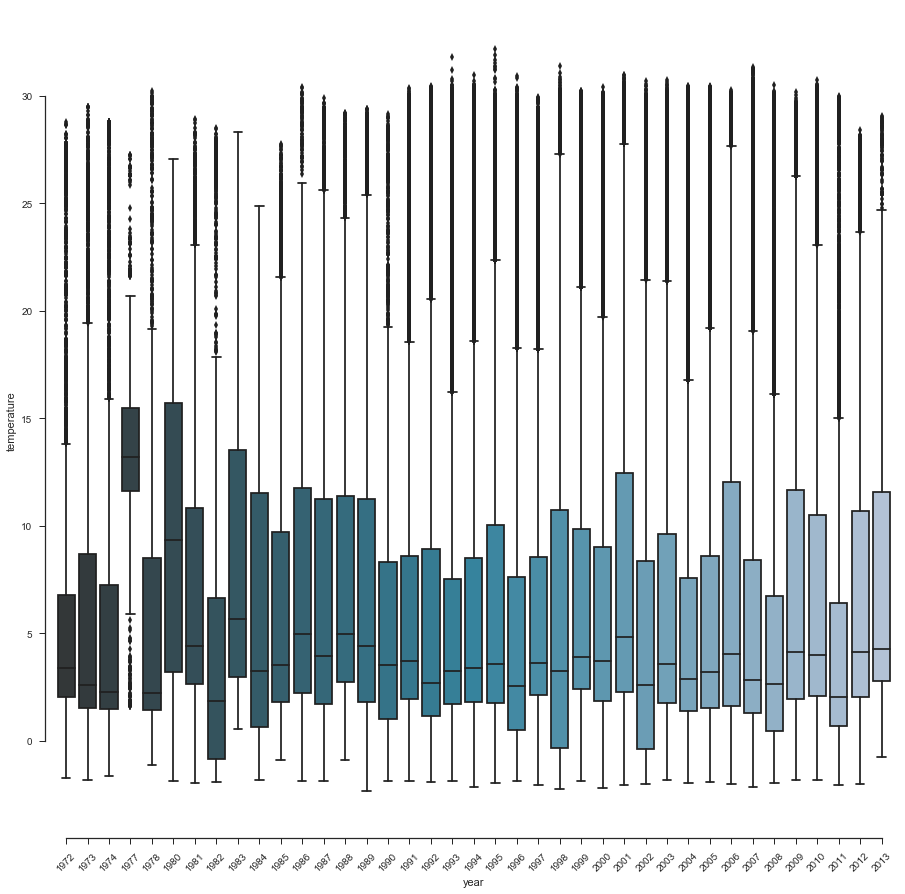

In [10]:
sns.set(style="ticks")

plt.figure(figsize=(15,15))

# Nested boxplot to show temperature over time
sns.boxplot(x='year', y='temperature', data=df, palette='PuBuGn_d')
sns.despine(offset=10, trim=True)
plt.xticks(rotation=45);

#### Variability in Measuring Depth Over Time

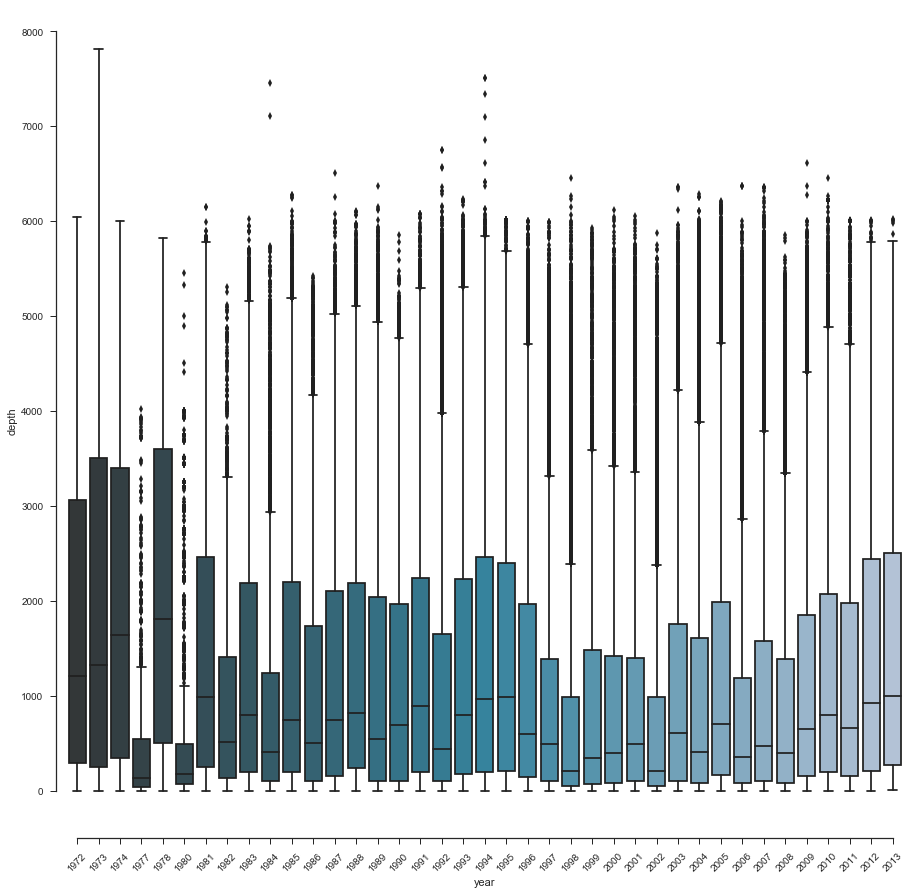

In [11]:
# Check for max-sample-depth over time

sns.set(style="ticks")

plt.figure(figsize=(15,15))

# Nested boxplot to show temperature over time
sns.boxplot(x='year', y='depth', data=df, palette='PuBuGn_d')
sns.despine(offset=10, trim=True)
plt.xticks(rotation=45);

In the first boxplot, notice that 1977 seemed like a very hot year. Here, we can see that the depth measured in 1977 was very close to the surface. This indicates that temperature and depth of measurement are correlated. This is important to keep in mind for further investigation. However, the years 1972 and 2013 appear to be similar enough, so I will hold off on changing anything with those and preceed. 

In [12]:
# Fill NaN values in temperature with mean of temperature

df['temperature'].fillna((df['temperature'].mean()), inplace=True)

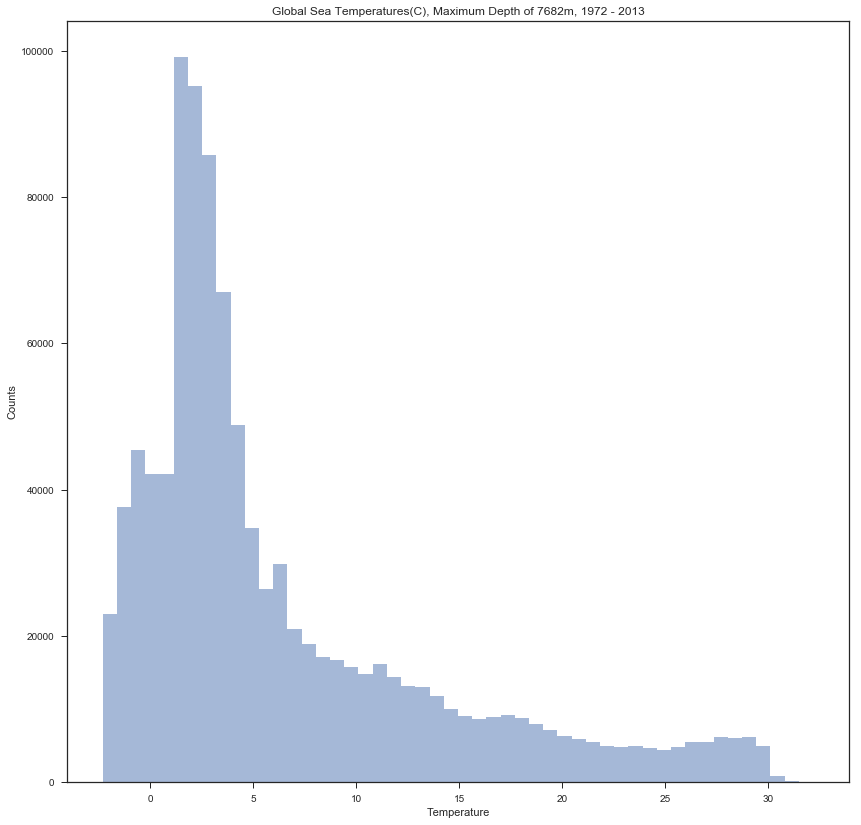

In [13]:
# Histogram of temperature for all years

fig = plt.figure(figsize=(14,14))
ax = fig.add_subplot(111)
plt.style.use('seaborn-darkgrid')

ax.hist(df['temperature'], bins=50, alpha=0.5)
plt.title('Global Sea Temperatures(C), Maximum Depth of 7682m, 1972 - 2013')
plt.xlabel('Temperature')
plt.ylabel('Counts');

In [14]:
# Create new dataframes with youngest year and oldest year separated

young_year = df[df['year'] == df['year'].min()]
old_year = df[df['year'] == df['year'].max()]

# Check max depth of measurements for those specific years

young_year['maxsampdepth'].max()
old_year['maxsampdepth'].max();

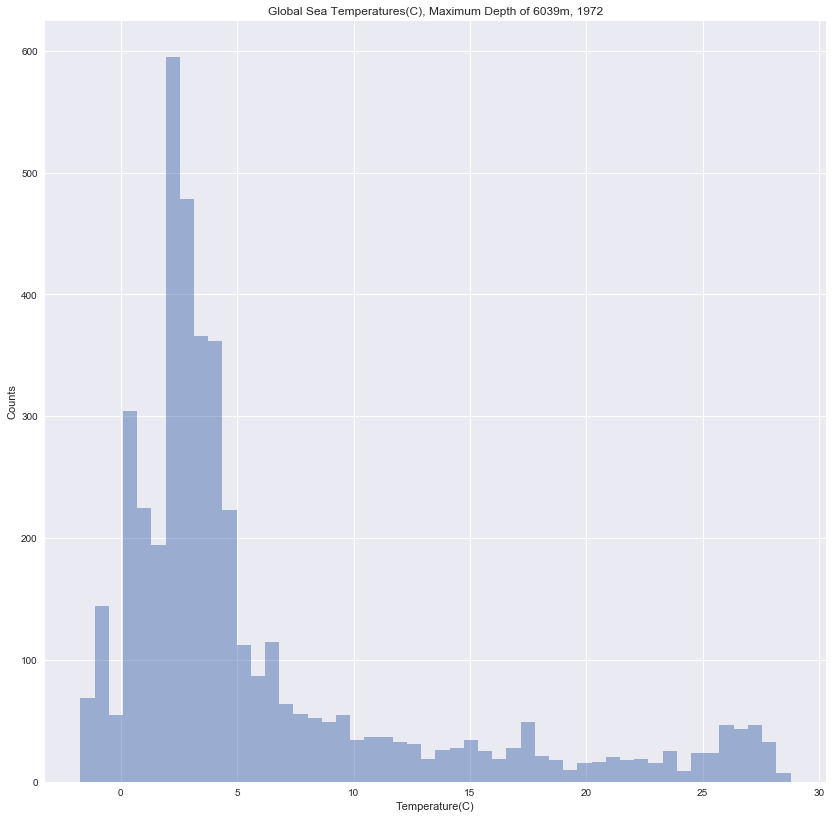

In [15]:
# Hist of Temperature in 1972

fig = plt.figure(figsize=(14,14))
ax = fig.add_subplot(111)
plt.style.use('seaborn-darkgrid')


ax.hist(young_year['temperature'], bins=50, alpha=0.5)
plt.title('Global Sea Temperatures(C), Maximum Depth of 6039m, 1972')
plt.xlabel('Temperature(C)')
plt.ylabel('Counts');

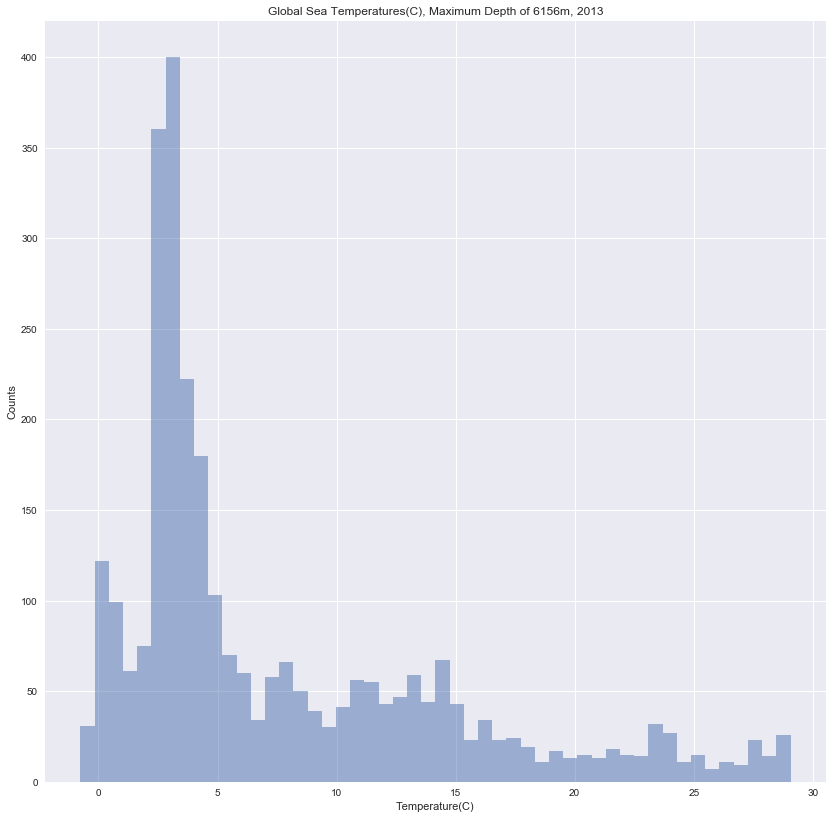

In [16]:
# Plot histogram with temperatures from 2013

fig = plt.figure(figsize=(14,14))
ax = fig.add_subplot(111)
plt.style.use('seaborn-darkgrid')

ax.hist(old_year['temperature'], bins=50, alpha=0.5)
plt.title('Global Sea Temperatures(C), Maximum Depth of 6156m, 2013')
plt.xlabel('Temperature(C)')
plt.ylabel('Counts');

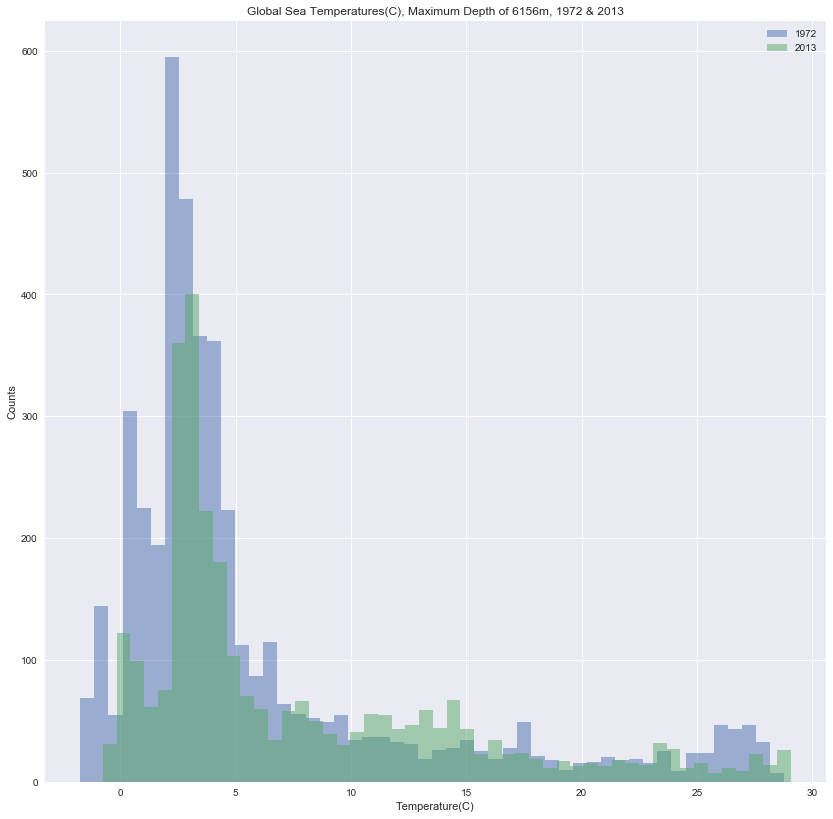

In [17]:
fig = plt.figure(figsize=(14,14))
ax = fig.add_subplot(111)


ax.hist(young_year['temperature'], bins=50, alpha=0.5, label='1972')
ax.hist(old_year['temperature'], bins=50, alpha=0.5, label='2013')
plt.legend(loc='upper right')
plt.xlabel("Temperature(C)")
plt.ylabel('Counts')
plt.title('Global Sea Temperatures(C), Maximum Depth of 6156m, 1972 & 2013')
plt.show();

## Hypothesis Testing

#### Welch's Ttest to Determine if there was a Significant Statistical Change in Temperature from 1972 - 2013

###### Was there a change in average sea temperature measured at a max depth of 7682m between the years of 1972 and 2013?

**Null**: There was no statistically significant change in sea temperature between 1972 & 2013 

**Alternative**: There was a statistically significant change in sea temperature between 1972 & 2013

*Test type*: Welch's two-tailed t-test (Welch's because I am assuming unequal variance between the datasets)

*Alpha*: 0.05

*Significance Level* = 0.025

In [18]:
a = young_year['temperature']
b = old_year['temperature']
young_year_mean = a.mean()
old_year_mean = b.mean()

welch_ttest = stats.ttest_ind(a, b, axis=0, equal_var=False)
print("Mean Temperature for 1972: ", young_year_mean)
print("Mean Temperature for 2013: ", old_year_mean)
print("---------------------------------------------")
print("P-value for Welch's T-test: ", welch_ttest[1])
print('---------------------------------------------')
print("Reject Null Hypothesis?: ", welch_ttest[1] <= 0.025)

Mean Temperature for 1972:  5.977030884026145
Mean Temperature for 2013:  7.620444281324687
---------------------------------------------
P-value for Welch's T-test:  1.38716440599e-22
---------------------------------------------
Reject Null Hypothesis?:  True


This is an incredibly small p-value, which suggests a statistically significant change between the two years.

## EDA for Regression Analysis

In [19]:
# Investigate to see if columns with NaN in relation to the year.

def get_percentage_missing(series):
    """ Calculates percentage of NaN values in DataFrame
    :param series: Pandas DataFrame object
    :return: float
    """
    num = series.isnull().sum()
    den = len(series)
    return round(num/den, 2)

# Only include columns that contain any NaN values
df_with_any_null_values = df[df.columns[df.isnull().any()].tolist()]

get_percentage_missing(df_with_any_null_values)

get_percentage_missing(df);

In [20]:
# Remove columns that contain only information on whether the value was quality control tested

cols_to_keep = ['cruise', 'station', 'cast', 'year', 'month', 'day', 'hour', 'minute', 'latitude', 'longitude', 'bottomdepth', 'maxsampdepth', 'bottle', 'pressure', 'depth', 'temperature', 'theta', 'salinity','gamma', 'oxygen', 'aou', 'nitrate', 'silicate','phosphate']
df = df[cols_to_keep]

In [21]:
get_percentage_missing(df);

In [22]:
# Made the decision to drop columns that were 70% NaN or higher

In [23]:
# Correlation heatmap with all features

def sns_heatmap(df):#, labels):

    '''a. Converts a categorical matrix into a dummy_matrix with ints
       b. Computes the correlations
       c. Maps on  Seaborn heatmap
       d. Because some labels are so long, replace those with
       indicated label
       Input: Pandas DataFrame, list
       Output: Seaborn correlation matrix'''

    # Convert categorical df types into ints so corr will work
    dummy_df = pd.get_dummies(df)

    # Compute the correlation matrix
    corr = dummy_df.corr()

    sns.set(style="white")

    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(16,16))
    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    # Draw the heatmap with the mask and correct aspect ratio

    # Generage plot. Optional argument mask left out
    cm = sns.heatmap(corr, cmap=cmap, vmax=.3, center=0,
    square=True, linewidths=.5, mask=mask, cbar_kws={"shrink": .5}, annot=True, fmt='.2f', annot_kws={"size":9})#,
    #xticklabels=labels, yticklabels=labels)

    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=45)

    plt.subplots_adjust(left=0.12, bottom=0.21, right=0.86, top=0.88,
                wspace=0.20, hspace=0.20)


    plt.show()

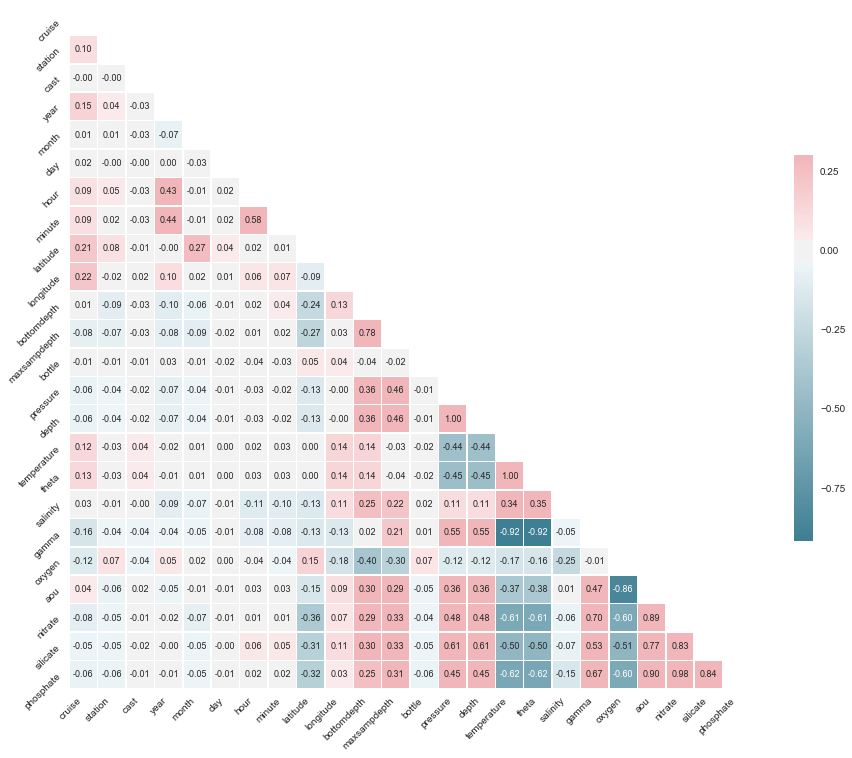

In [24]:
sns_heatmap(df)

#### Closer Look at Some Correlations

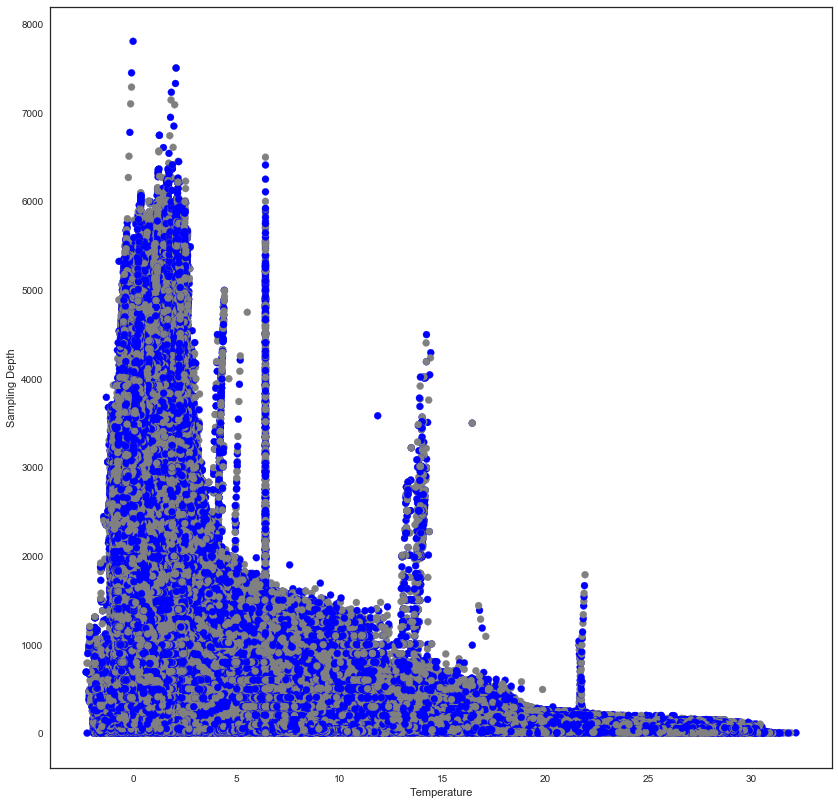

In [25]:
# Sampling Depth and Temperature, Negative Correlation -0.44


fig, ax = plt.subplots(figsize=(14, 14))
ax.scatter(df["temperature"], df["depth"], color=["grey", 'blue'], )
ax.set_xlabel("Temperature"); ax.set_ylabel("Sampling Depth")
plt.style.use('seaborn-darkgrid')
plt.show();

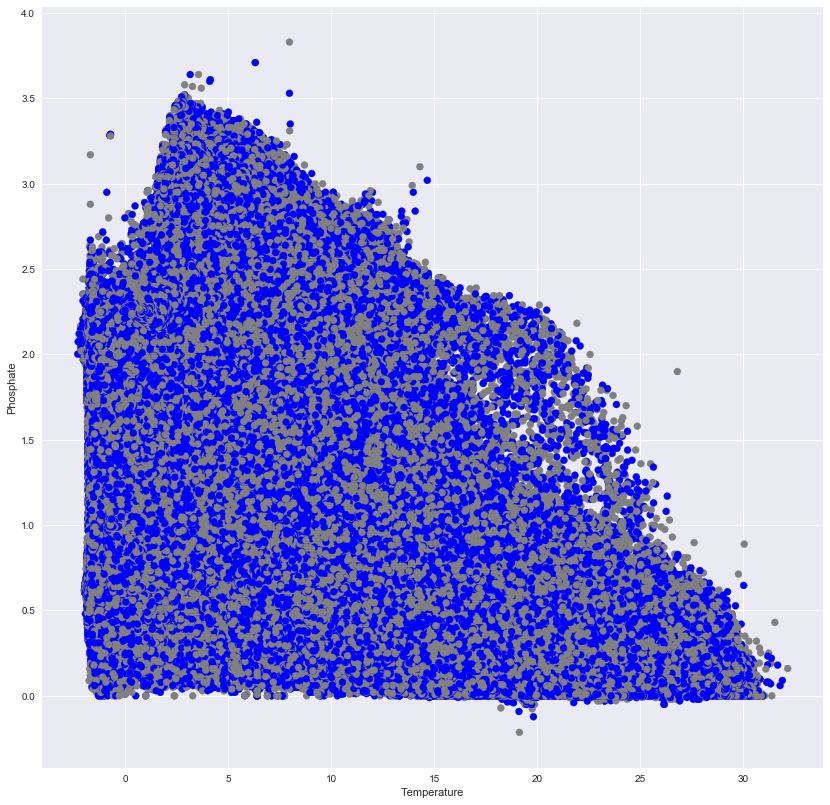

In [26]:
# Phosphate and Temperature, Negative correlation -0.62

fig, ax = plt.subplots(figsize=(14, 14))
ax.scatter(df["temperature"], df["phosphate"], color=["grey", 'blue'])
ax.set_xlabel("Temperature"); ax.set_ylabel("Phosphate")
plt.style.use('seaborn-darkgrid')
plt.show();

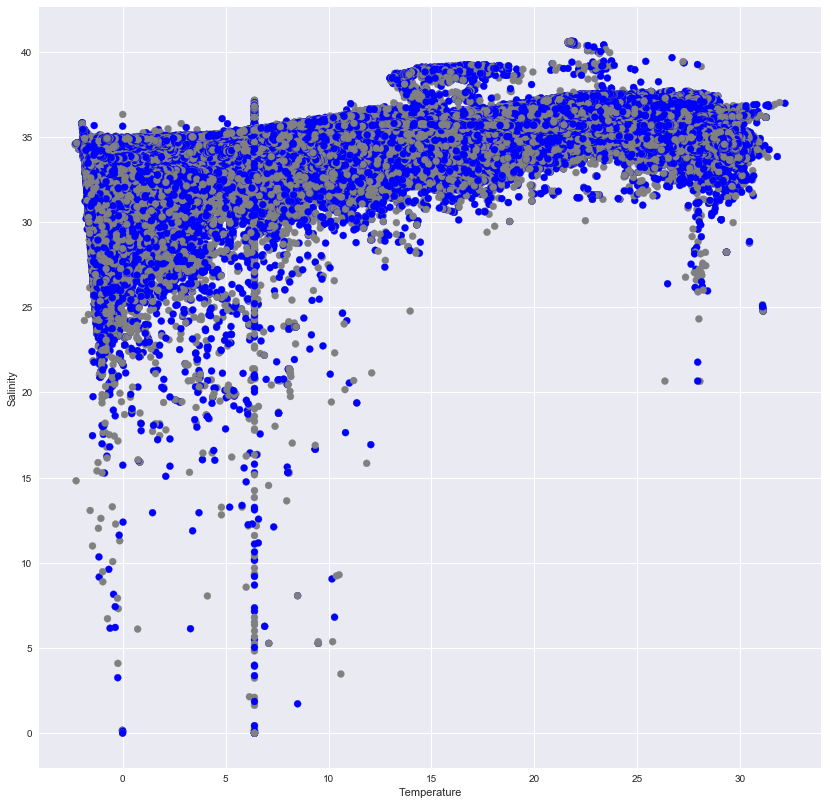

In [27]:
# Temperature and salinity, Positive correlation 0.34

fig, ax = plt.subplots(figsize=(14, 14))
ax.scatter(df["temperature"], df["salinity"], color=["grey", 'blue'])
ax.set_xlabel("Temperature"); ax.set_ylabel("Salinity")
plt.style.use('seaborn-darkgrid')
plt.show();

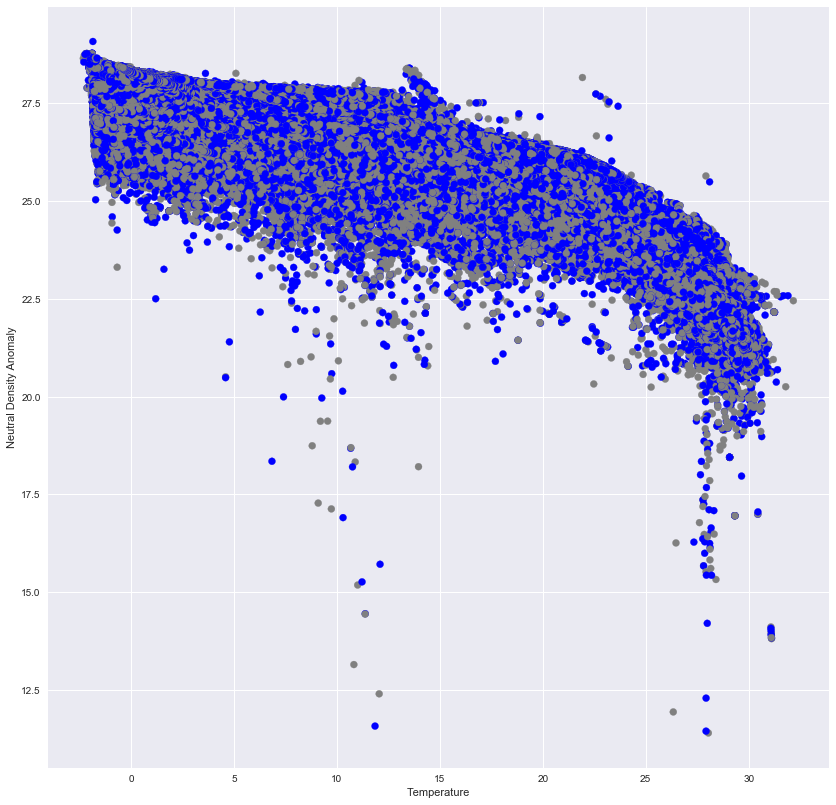

In [28]:
fig, ax = plt.subplots(figsize=(14, 14))
ax.scatter(df["temperature"], df["gamma"], color=["grey", 'blue'])
ax.set_xlabel("Temperature"); ax.set_ylabel("Neutral Density Anomaly")
plt.style.use('seaborn-darkgrid')
plt.show();

#### Lasso, Ridge, Elastic Net Analysis

In [29]:
# Fill any columns with less than 30% of NaN values with mean

for column in cols_to_keep:
    if get_percentage_missing(df[f'{column}']) <= 0.30:
        df[f'{column}'].fillna((df[f'{column}'].mean()), inplace=True)

In [30]:
df.columns

Index(['cruise', 'station', 'cast', 'year', 'month', 'day', 'hour', 'minute',
       'latitude', 'longitude', 'bottomdepth', 'maxsampdepth', 'bottle',
       'pressure', 'depth', 'temperature', 'theta', 'salinity', 'gamma',
       'oxygen', 'aou', 'nitrate', 'silicate', 'phosphate'],
      dtype='object')

In [31]:
get_percentage_missing(df)

cruise          0.0
station         0.0
cast            0.0
year            0.0
month           0.0
day             0.0
hour            0.0
minute          0.0
latitude        0.0
longitude       0.0
bottomdepth     0.0
maxsampdepth    0.0
bottle          0.0
pressure        0.0
depth           0.0
temperature     0.0
theta           0.0
salinity        0.0
gamma           0.0
oxygen          0.0
aou             0.0
nitrate         0.0
silicate        0.0
phosphate       0.0
dtype: float64

#### Split Data & Standardize

1. Split the original df into features and target. This will create a new df that contains only your features. The target is left alone in the original df. 
2. Split the features df and the target df into training and testing sets. The model still hasn't seen the target at this point.
3. Standardize. Fit your standardizer to the X_training data. Then transform onto the X_train and the X_test. It is important to not show the model the target, and it is important that the standardizer is fit to the training data and not the testing data. 

In [33]:
features = df[['cruise', 'station', 'cast', 'year', 'month', 'day', 'hour', 'minute',
       'latitude', 'longitude', 'bottomdepth', 'maxsampdepth', 'bottle',
       'pressure', 'depth','salinity', 'gamma','oxygen', 'aou', 'nitrate', 'silicate', 'phosphate']]

target1 = df['temperature']
target2 = df['theta']

In [34]:
# Split the features df and the target into training and testing data
# ERIN, MAKE THE DF INTO NP ARRAYS BY TYPING VALUES

X_train, X_test, y_train, y_test = train_test_split(features.values, target1.values, test_size=0.25)

In [35]:
# Standardize my features. Fit to X_train, transform onto X_train and X_test

standardizer = StandardScaler()
standardizer.fit(X_train)

X_train_stand = standardizer.transform(X_train)
X_test_stand = standardizer.transform(X_test)

#### Ridge

In [36]:
'''RMSE function'''

def rmse(true,predicted):
    
    sum_list = []
    for idx, each in enumerate(predicted):
        sum_list.append((predicted[idx] - true[idx])**2)
    sum_mean = np.mean(sum_list)
    rmse = np.sqrt(sum_mean)

    return rmse

In [38]:
'''Ridge'''''
#Performs L2 regularization, i.e. adds penalty equivalent to square of the magnitude of coefficients
#Minimization objective = LS Obj + α * (sum of square of coefficients)

#Ridge Regression on the training data only
ridge_regress = Ridge(alpha=0.5)
ridge_regress.fit(X_train_stand, y_train)

# Call predict to get the predicted values for
#training and test set
train_predicted = ridge_regress.predict(X_train_stand)
test_predicted = ridge_regress.predict(X_test_stand)

# Calculate RMSE for training and test set
print('RMSE for training set:', rmse(y_train, train_predicted))
print('RMSE for test set:', rmse(y_test, test_predicted))

RMSE for training set: 2.34466483288
RMSE for test set: 2.33795281076


#### Ridge with Cross Val

In [40]:
ridge_cv = RidgeCV(alphas=(0.1, 1.0, 10.0), fit_intercept=True, normalize=True, cv=2)
ridge_cv.fit(X_train_stand, y_train)

ridgecv_train_predicted = ridge_cv.predict(X_train_stand)
ridgecv_test_predicted = ridge_cv.predict(X_test_stand)

print('RMSE for training set:', rmse(y_train, ridgecv_train_predicted))
print('RMSE for test set:', rmse(y_test, ridgecv_test_predicted))

RMSE for training set: 2.4654738619
RMSE for test set: 2.45981418498


In [91]:
kf = KFold(n_splits=3, random_state=12, shuffle=False)

alpha_rmse_r = []

for alp in [7, 8, 10, 15]:
    model_r = Ridge(alpha=alp)
    
    fold_rmses_r = []
    for train_idx, test_idx in kf.split(X_train_stand):
        
        X_train_r = X_train_stand[train_idx]
        X_test_r = X_train_stand[test_idx]
        
        y_train_r = y_train[train_idx]
        y_test_r = y_train[test_idx]
        
        model_r.fit(X_train_r, y_train_r)
        
        train_predicted_r = model_r.predict(X_train_stand[train_idx])
        test_predicted_r = model_r.predict(X_train_stand[test_idx])
        
        y_test_pred = model_r.predict(X_test_r)
        
        train_rmse_r = rmse(train_predicted_r, y_train[train_idx])
        test_rmse_r = rmse(y_test_pred, y_test_r)
        
        fold_rmses_r.append(test_rmse_r)
        
    alpha_rmse_r.append(np.mean(fold_rmses_r))

In [92]:
print(alpha_rmse_r)

[2.3452430833977425, 2.3452430833977425, 2.3452430833977425, 2.3452430833977425]


Lowest RMSE: 2.3457

Alpha: 10

#### Lasso with Cross Val

In [93]:
kf = KFold(n_splits=3, random_state=12, shuffle=False)

alpha_rmse_l = []

for alp in [0.0001, 0.001, 0.01, 1]:
    model_l = Lasso(alpha=alp)
    
    fold_rmses_l = []
    for train_idx, test_idx in kf.split(X_train_stand):
        
        X_train_l = X_train_stand[train_idx]
        X_test_l = X_train_stand[test_idx]
        
        y_train_l = y_train[train_idx]
        y_test_l = y_train[test_idx]
        
        model_l.fit(X_train_l, y_train_l)
        
        train_predicted_l = model_l.predict(X_train_stand[train_idx])
        test_predicted_l = model_l.predict(X_train_stand[test_idx])
        
        y_test_pred_l = model_l.predict(X_test_l)
        
        train_rmse_l = rmse(train_predicted_l, y_train[train_idx])
        test_rmse_l = rmse(y_test_pred_l, y_test_l)
        
        fold_rmses_l.append(test_rmse_l)
        
    alpha_rmse_l.append(np.mean(fold_rmses_l))

In [98]:
alpha_rmse_l

[2.3452135303280461, 2.3452310990700025, 2.3459357235443381, 3.343941906694031]

Lowest RMSE: 3.3439

Alpha: 1

### ElasticNet with Cross Val

In [109]:
kf = KFold(n_splits=3, random_state=12, shuffle=False)

alpha_rmse_e = []

for alp in [0.00001, 0.0001, 0.001]:
    model_e = ElasticNet(alpha=alp, l1_ratio=(0.5))
    
    fold_rmses_e = []
    test_rmses_e = []
    train_rmses_e = []
    for train_idx, test_idx in kf.split(X_train_stand):
        
        X_train_e = X_train_stand[train_idx]
        X_test_e = X_train_stand[test_idx]
        
        y_train_e = y_train[train_idx]
        y_test_e = y_train[test_idx]
        
        model_e.fit(X_train_e, y_train_e)
        
        train_predicted_e = model_e.predict(X_train_stand[train_idx])
        test_predicted_e = model_e.predict(X_train_stand[test_idx])
        
        y_test_pred_e = model_e.predict(X_test_e)
        
        train_rmse_e = rmse(train_predicted_e, y_train[train_idx])
        test_rmse_e = rmse(y_test_pred_e, y_test_e)
        test_rmses_e.append(test_rmse_e)
        train_rmses_e.append(train_rmse_e)
        
        fold_rmses_e.append(test_rmse_e)
        
    alpha_rmse_e.append(np.mean(fold_rmses_e))

In [114]:
print(test_rmses_e)
print(train_rmses_e)

[2.3555288900315094, 2.3454894804565196, 2.3347108797051983]
[2.3398279501630892, 2.3447490494258667, 2.3501513885139778]


Lowest RMSE: 2.345205

Alpha: 0.00001

Ratio: 0.5

In [111]:
fold_rmses_e

[2.3555288900315094, 2.3454894804565196, 2.3347108797051983]

In [112]:
# Stopped with trying to plot RMSE and alphas. 

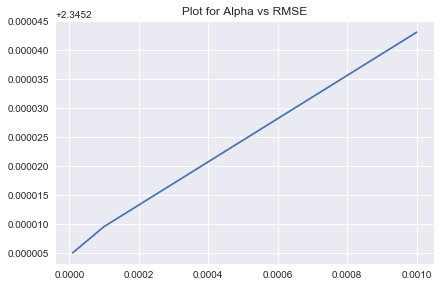

In [106]:
plt.subplot()

plt.tight_layout()

plt.plot([0.00001, 0.0001, 0.001],alpha_rmse_e)
#plt.plot(X_train_stand ,target1,'.')

plt.title('Plot for Alpha vs RMSE')

In [ ]:
pl.plot(alpha, t_rmse, label='RMSE-Train')
pl.plot(alpha, cv_rmse, label='RMSE_XVal')
pl.legend( ('RMSE-Train', 'RMSE_XVal') )
pl.ylabel('RMSE')
pl.xlabel('Alpha')
pl.show()

In [ ]:
ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Ridge coefficients as a function of the regularization')
plt.axis('tight')
plt.show()

In [ ]:
# These are for plotting because the x and y have to be the same length

# random_original = df['temperature'].sample(n=249845)

# print(len(y_test_pred))
# print(len(random_original))

ValueError: x and y must have same first dimension, but have shapes (3,) and (1,)

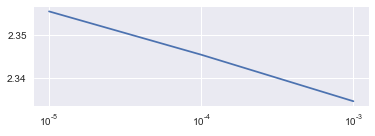

In [113]:
plt.subplot(2, 1, 1)
plt.semilogx([0.00001, 0.0001, 0.001], fold_rmses_e, label='Train')
plt.semilogx([0.00001, 0.0001, 0.001], test_rmse_e, label='Test')
#plt.vlines(alpha_optim, plt.ylim()[0], np.max(test_errors), color='k',
#           linewidth=3, label='Optimum on test')
plt.legend(loc='lower left')
plt.ylim([0, 1.2])
plt.xlabel('Regularization parameter')
plt.ylabel('Performance')